In [2]:
#import usefull libraries
import pandas as pd
import numpy as np
import scipy
from matplotlib import pyplot as plt
from scipy.stats import norm

# Rate of change
The time series were analyzed the following way:
- No trend were considered
- The seasonality, while considerable, was not considered
- Each signals were normalized, thus have a variance of 1 and a mean of 0
The $\sigma$-rate of change was defined as the number of days needed to have a change of $\sigma$ starting from any date

In [3]:
#load the data:
#data_path = "..\\Datasets\\Forecasting_aqua\\data_h_clean_v2.csv"
data_path = "..\\Datasets\\Forecasting_aqua\\data_h_clean_v2.csv"
format = "%d-%m-%Y"
df = pd.read_csv(data_path)
time_df = pd.to_datetime(df["Datetime"], infer_datetime_format=True)

df.drop("sample",axis=1,inplace=True,errors='ignore')

df['Datetime']= time_df
keys_imp = ['ciliate','mean_chla','cv_chla_day','cv_chla_depth',
            'nauplius','Ammonium','Nitrat','mean_schmidt','windspeed_max',
            'mean_thermocline_depth','mean_epi_temp','mean_oxycline_depth',
            'mean_mixed_layer_depth','mean_global_radiation'
           ]
df['year'] = df['Datetime'].dt.year
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day
dft = df.set_index('Datetime')
#drop the first datapoints the first months are only meteorological data
#first_point = (~df['mean_chla'].isnull()).idxmax()
#dfs = df.drop(index=range(first_point))
#df = dfs.reset_index(drop=True)

In [4]:
#normalize
df_std = (dft-dft.mean())/dft.std()

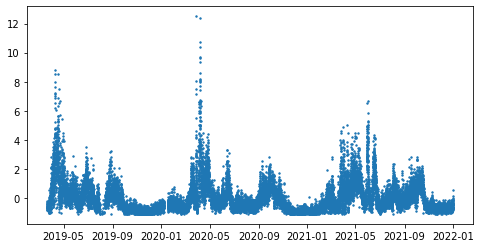

In [5]:
#show an example:
key = 'nauplius'
fig,ax = plt.subplots(1,figsize=(8,4))
plt.scatter(df_std.index,df_std[key],s=2)

For the nauplius measurement, the time needed to have
a change of 1 sigma starting from 2020-01-01 02:00:00 is 26 days 08:00:00


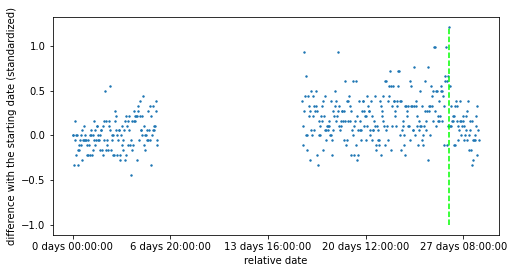

In [92]:
#define a function that find the sigma rate of change of a given starting date
def sigma_roc_from(serie, start_datetime, sigma = 1):
    start_datetime = pd.to_datetime(start_datetime, infer_datetime_format=True)
    val_or = serie[start_datetime]
    idx_or = 0
    for idx,val in enumerate(serie[start_datetime:]):
        #check if nan
        if val_or != val_or:
            return np.nan
        if abs(val_or-val)> sigma:
            return serie[start_datetime:].index[idx]-start_datetime
    return np.nan
#print an example:
key = 'nauplius'
start_datetime = '2020-01-01 02:00:00'
sigma = 1
roc = sigma_roc_from(df_std[key],start_datetime,sigma)

print(f"For the {key} measurement, the time needed to have\n"+
      f"a change of {sigma} sigma starting from {start_datetime} is {roc}")

fig,ax = plt.subplots(1,figsize=(8,4))
start_datetime = pd.to_datetime(start_datetime, infer_datetime_format=True)
ref = start_datetime
ax.scatter(pd.date_range(start=ref, end=ref+roc+pd.Timedelta(50,'h'),freq='H')
          ,df_std[key][start_datetime:start_datetime+roc+pd.Timedelta(50,'h')]-df_std[key][start_datetime],s=2)

ax.vlines(roc+ref,
          min(-1,df_std[key][start_datetime+roc]-df_std[key][start_datetime]),
          max(1,df_std[key][start_datetime+roc]-df_std[key][start_datetime])
          ,color = 'lime',linestyle='dashed')
ax.set_xticks(pd.date_range(start=ref, end=ref+roc+pd.Timedelta(24,'h'),periods=5))
ax.set_xticklabels(pd.date_range(start=ref, end=ref+roc+pd.Timedelta(24,'h'),periods=len(ax.get_xticks()))-ref)
ax.set_ylabel("difference with the starting date (standardized)")
ax.set_xlabel("relative date")
plt.show()

This measurement is not trustworthy on its own, so it is done for all starting dates

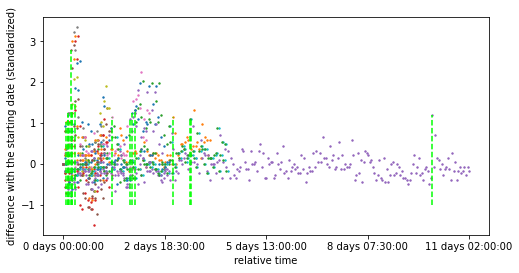

In [107]:
key = 'nauplius'
start_datetimes = ['2019-05-01 02:00:00','2021-07-02 02:00:00',
                   '2020-05-01 02:00:00','2019-07-02 02:00:00',
                   '2021-05-01 02:00:00','2020-07-02 02:00:00',
                   '2020-05-01 03:00:00','2021-07-02 03:00:00',
                   '2019-05-01 03:00:00','2019-07-02 03:00:00',
                   '2021-05-01 03:00:00','2020-07-02 03:00:00',
                   '2019-05-01 04:00:00','2021-07-02 04:00:00',
                   '2020-05-01 04:00:00','2019-07-02 04:00:00',
                   '2021-05-01 04:00:00','2020-07-02 04:00:00',
                   '2020-05-01 05:00:00','2021-07-02 05:00:00',
                   '2019-05-01 05:00:00','2019-07-02 05:00:00',
                   '2021-05-01 05:00:00','2020-07-02 05:00:00']
sigma = 1


fig,ax = plt.subplots(1,figsize=(8,4))
max_roc = pd.Timedelta(0)
for start_datetime in start_datetimes:
    roc = sigma_roc_from(df_std[key],start_datetime,sigma)
    #check if nan
    if roc != roc:
        continue



    start_datetime = pd.to_datetime(start_datetime, infer_datetime_format=True)
    ref = pd.to_datetime(start_datetimes[0], infer_datetime_format=True)
    ax.scatter(pd.date_range(start=ref, end=ref+roc+pd.Timedelta(24,'h'),freq='H')
              ,df_std[key][start_datetime:start_datetime+roc+pd.Timedelta(24,'h')]-df_std[key][start_datetime],s=2)

    ax.vlines(roc+ref,
              min(-1,df_std[key][start_datetime+roc]-df_std[key][start_datetime]),
              max(1,df_std[key][start_datetime+roc]-df_std[key][start_datetime]),
              color = 'lime',linestyle='dashed')
    if roc > max_roc:
        max_roc = roc
ax.set_xticks(pd.date_range(start=ref, end=ref+max_roc+pd.Timedelta(24,'h'),periods=5))
ax.set_xticklabels(pd.date_range(start=ref, end=ref+max_roc+pd.Timedelta(24,'h'),periods=len(ax.get_xticks()))-ref)
ax.set_ylabel("difference with the starting date (standardized)")
ax.set_xlabel("relative time")
plt.show()

In [51]:
#define a function to measure the roc of all the possible starting time
def sigma_roc_all(serie,sigma=1):
    list_roc = []
    for start_datetime in serie.index:
        list_roc.append(sigma_roc_from(serie,start_datetime,sigma))
    return pd.Series(list_roc)
res = sigma_roc_all(df_std[key])

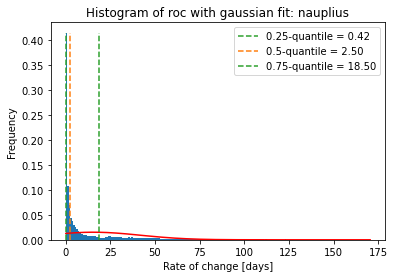

In [52]:
#define a function that build a histogram of the different rate of change
def hist_roc(serie_roc,title,quantiles=[0.25,0.5,0.75],pdf = None):
    roc_days = np.array([el.total_seconds()/24/3600 for el in serie_roc])
    n_val = pd.notna(serie_roc).sum()
    
    fig,ax = plt.subplots(1)
    n,bins,_ = ax.hist(roc_days,200,density=True)
    x_ax = np.linspace(bins[0],bins[-1],200)
    mean = np.nanmean(roc_days)
    std = np.nanstd(roc_days)
    p = np.nanquantile(roc_days,q=quantiles)
    ax.plot(x_ax, norm.pdf(x_ax, mean, std),'r')
    arts = [ax.vlines(pi,0,np.max(n),colors=plt.get_cmap('tab10')(idx+1),linestyle='dashed')
            for idx,pi in zip([1,0,1],p)]
    ax.set_title(f"Histogram of roc with gaussian fit: {title}")
    ax.set_xlabel("Rate of change [days]")
    ax.set_ylabel("Frequency")
    ax.legend(arts,[f"{quantile}-quantile ="+" {:.2f}".format(pi) for quantile, pi in zip(quantiles,p)])    
    plt.show()
    if pdf is not None:
        pdf.savefig(fig)
hist_roc(res,key)


For most of the variables, the histogram looks like a high number of roc is obtain after only one day (or less). As it then does not look like a Normal distribution, using the median instead of the mean value was preferred to aggregate the data into one value 

In [108]:
#compute the roc of all keys:
sigma = 1

dfroc = pd.DataFrame()
for idx,key in enumerate(df_std.keys()):
    print(f"processing roc {idx}/{len(df_std.keys())}",end='\r')
    #defragment the dataframe
    if idx%100==99:
        dfroc = dfroc.copy()
    dfroc[key] = sigma_roc_all(df_std[key],sigma)

In [372]:
dfroc=dfroc.copy()

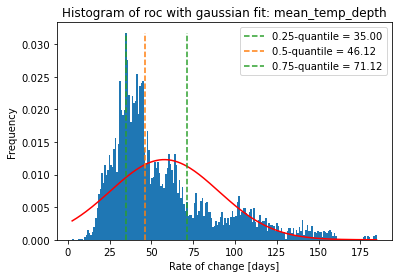

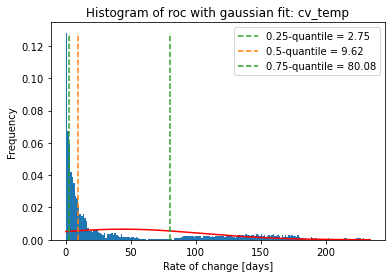

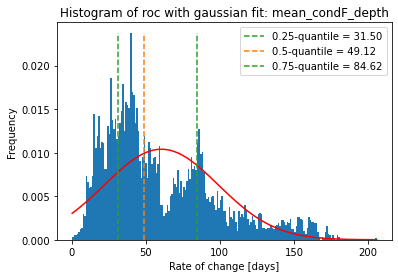

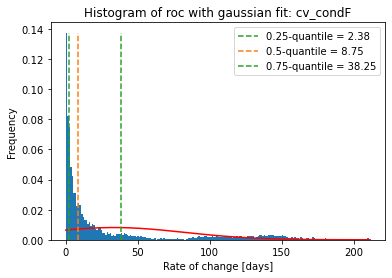

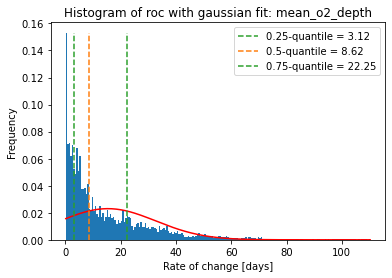

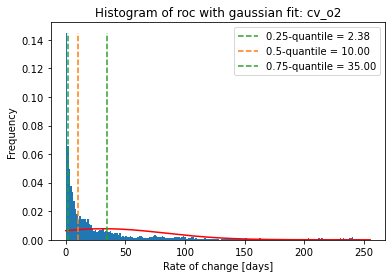

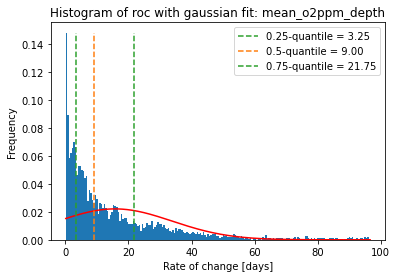

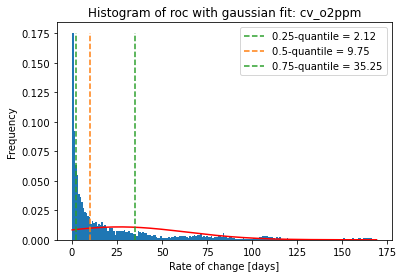

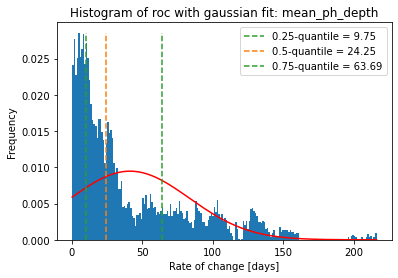

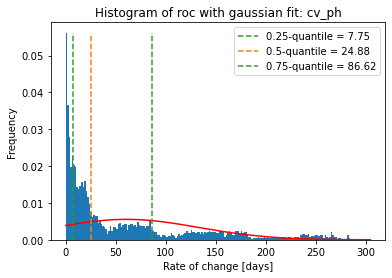

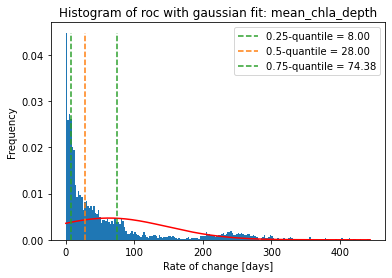

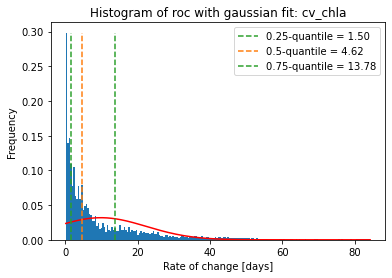

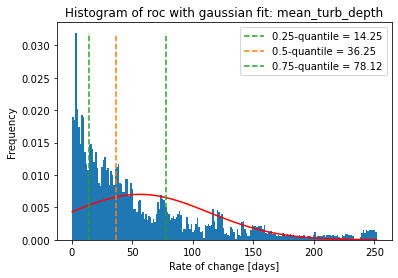

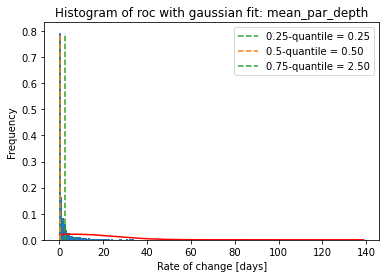

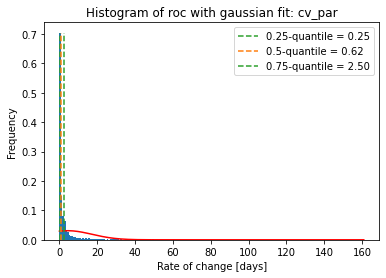

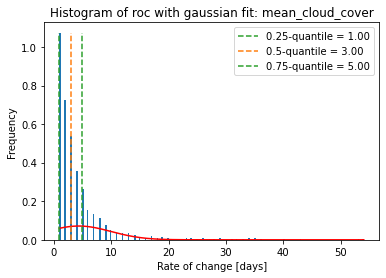

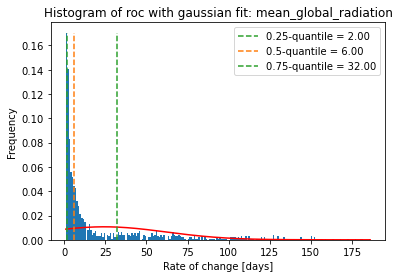

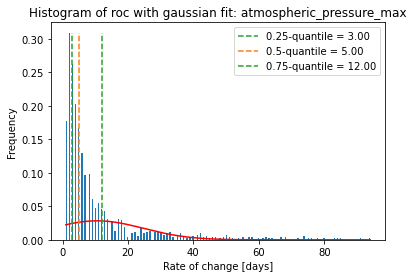

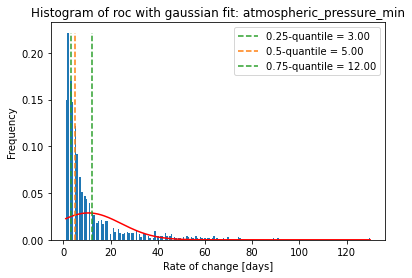

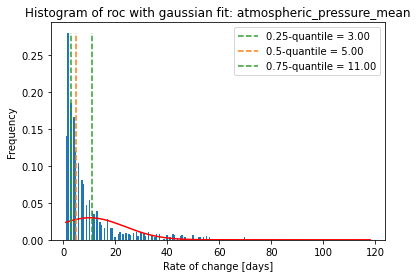

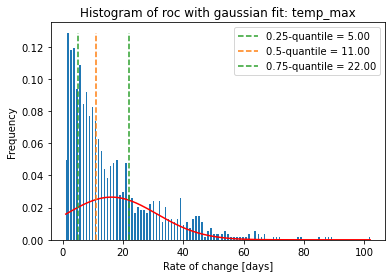

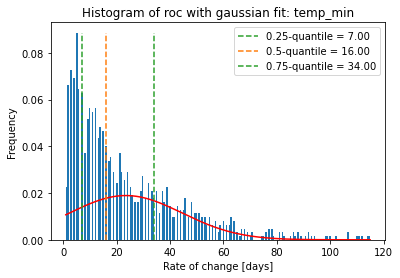

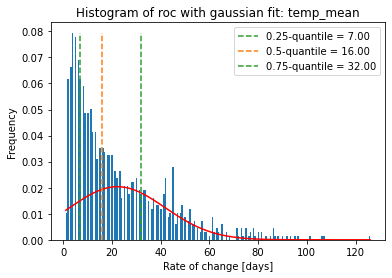

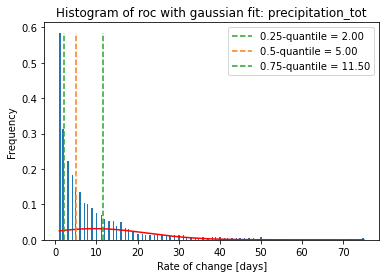

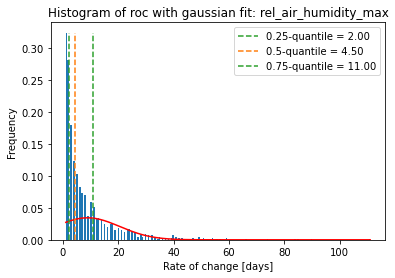

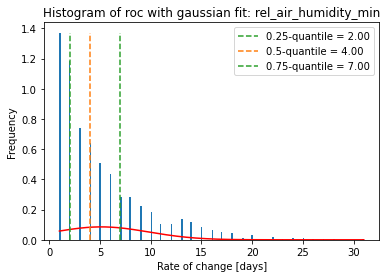

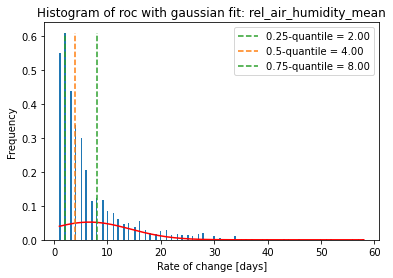

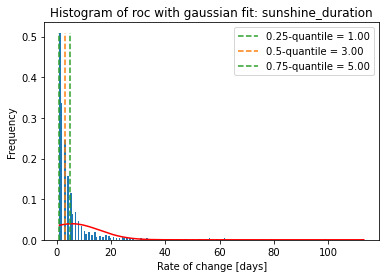

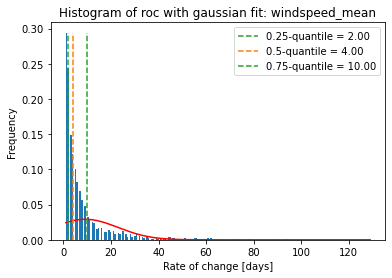

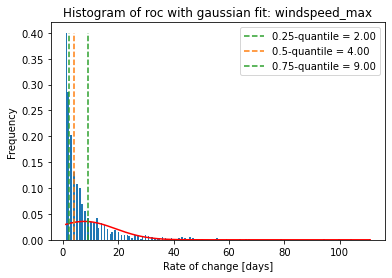

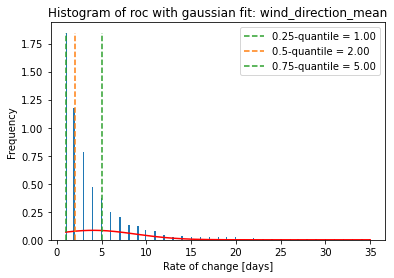

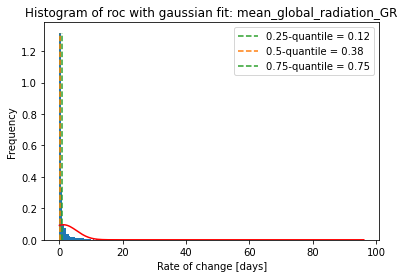

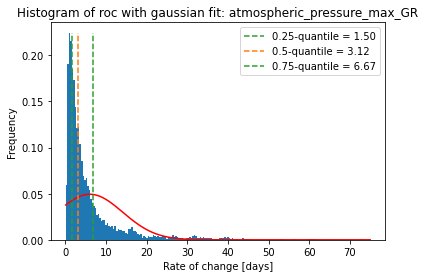

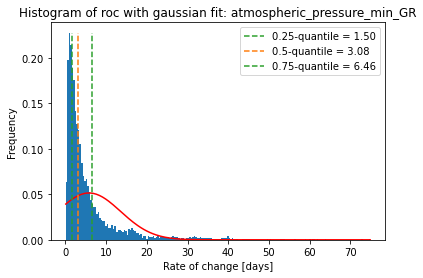

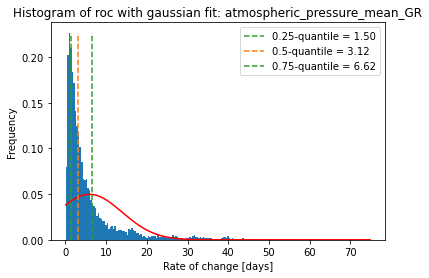

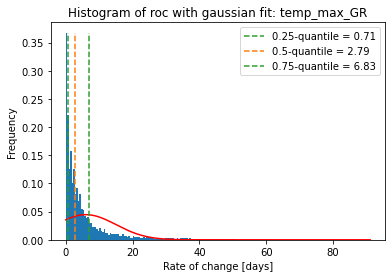

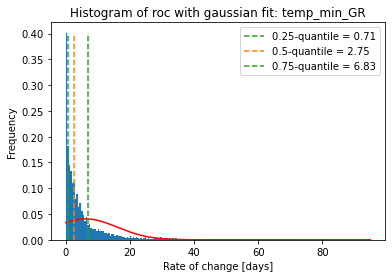

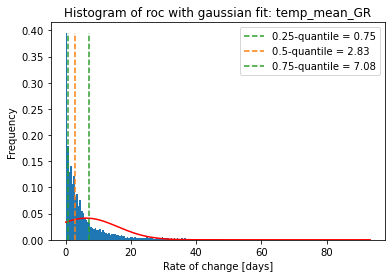

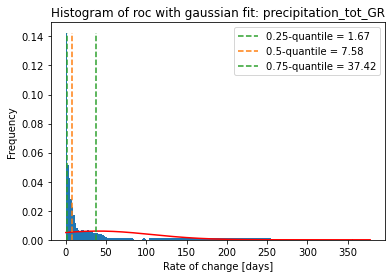

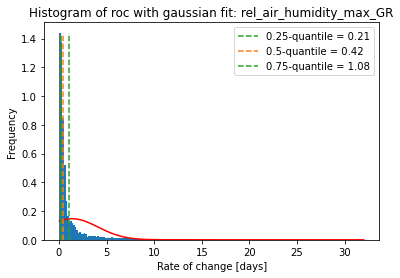

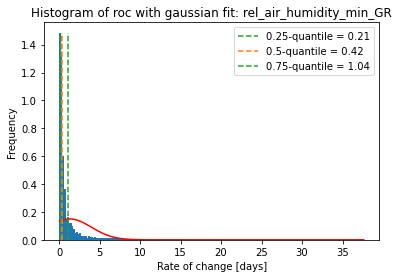

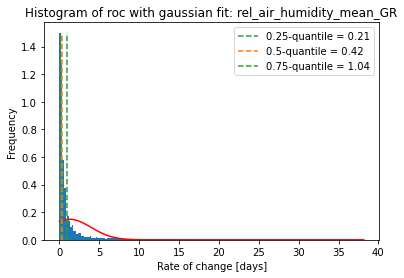

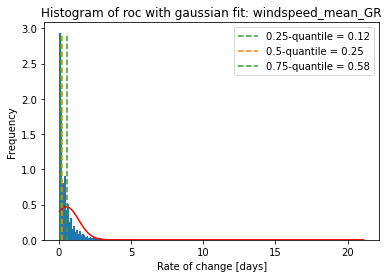

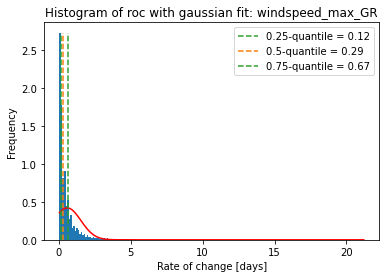

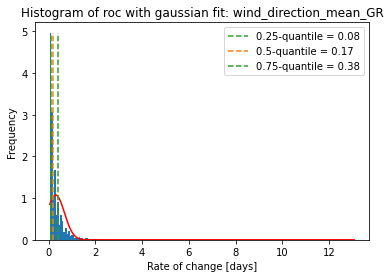

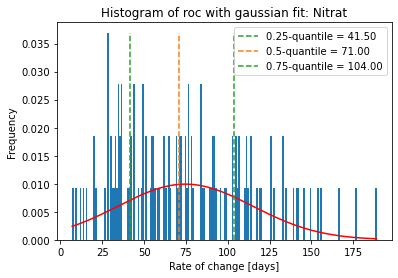

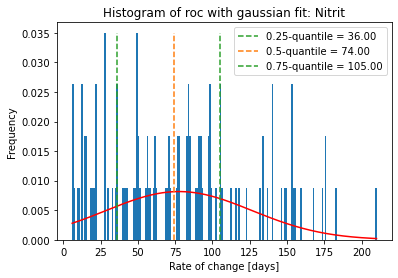

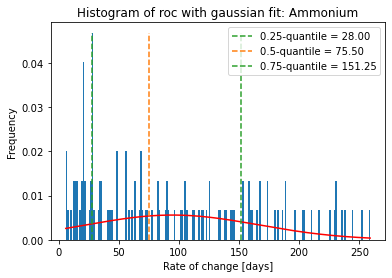

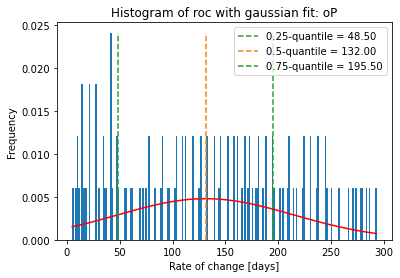

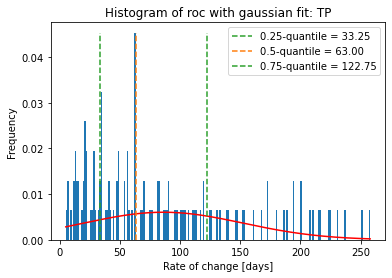

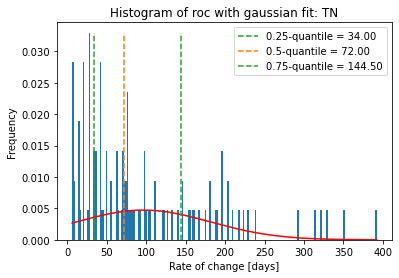

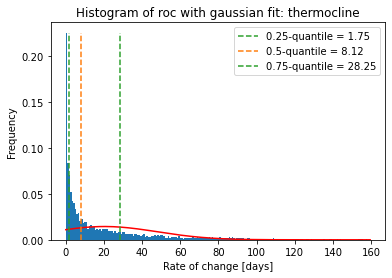

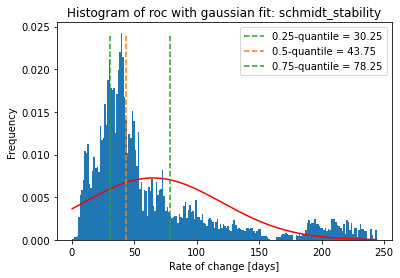

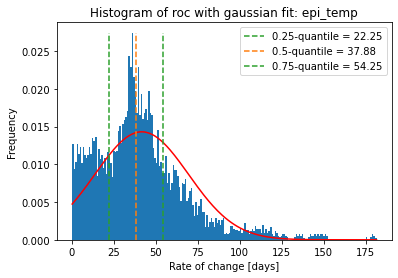

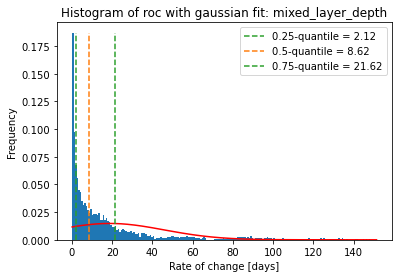

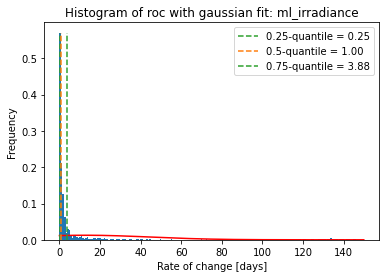

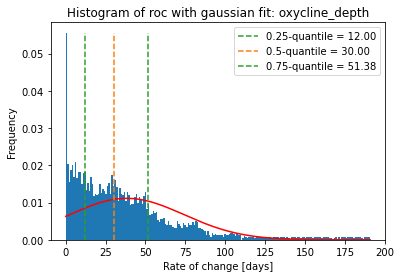

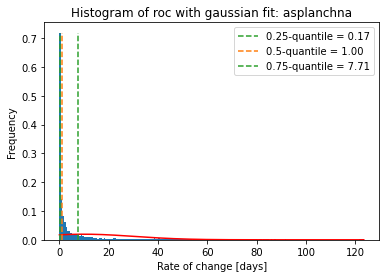

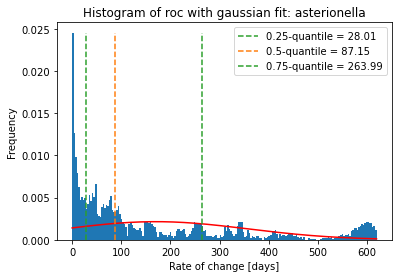

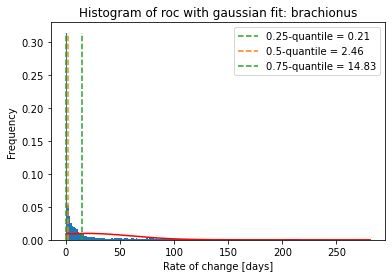

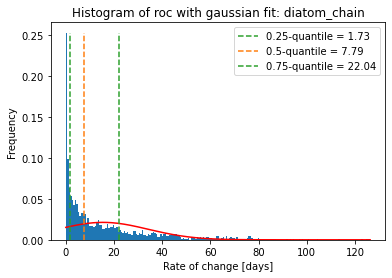

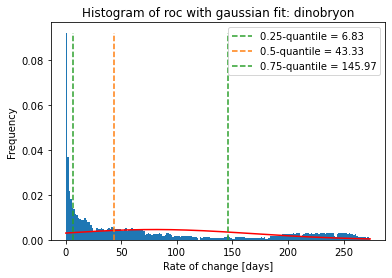

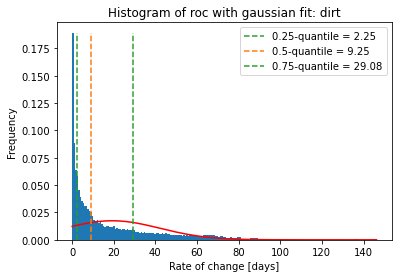

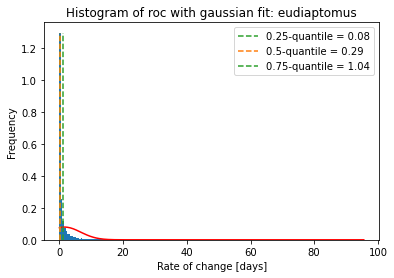

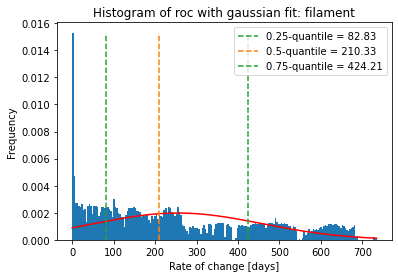

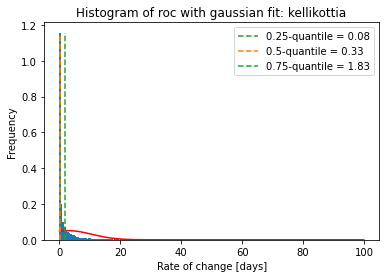

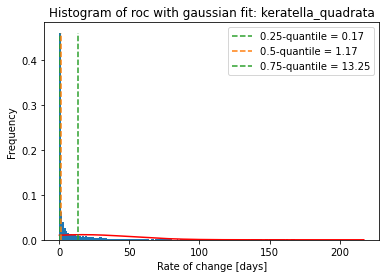

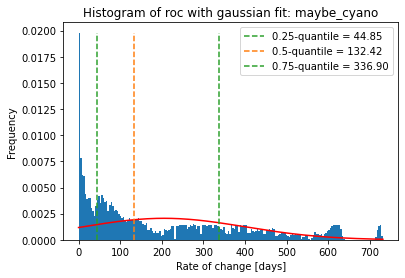

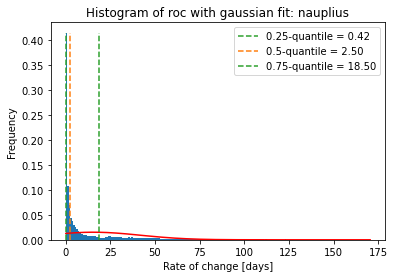

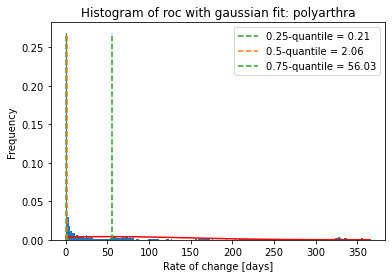

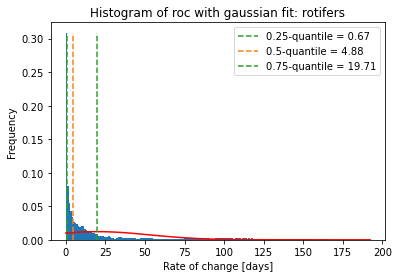

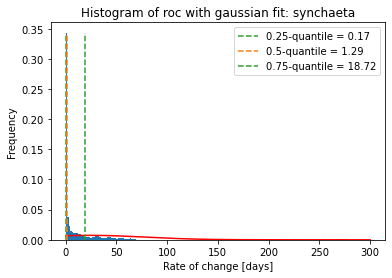

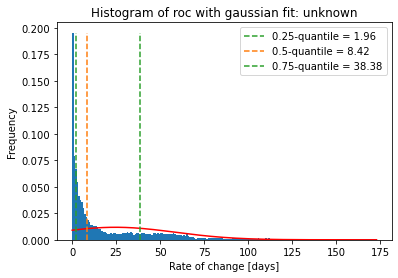

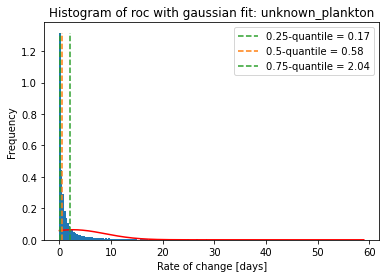

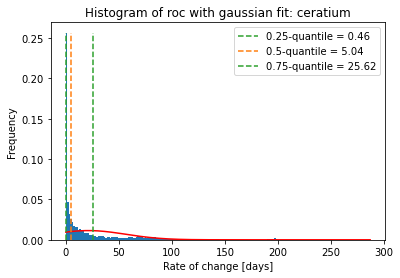

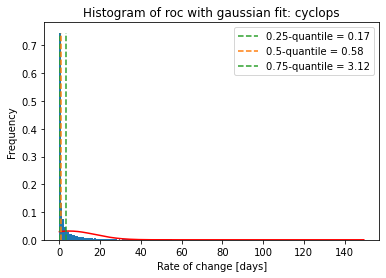

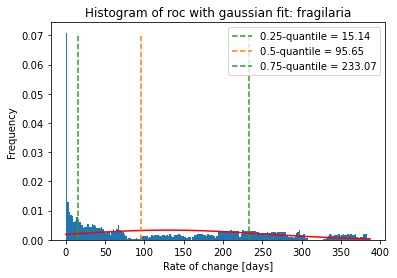

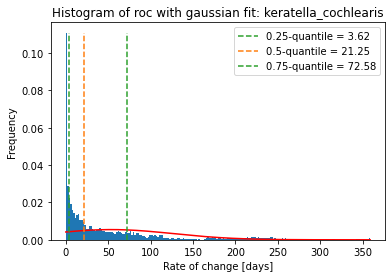

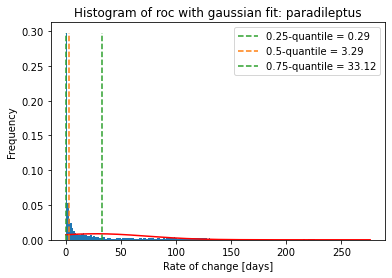

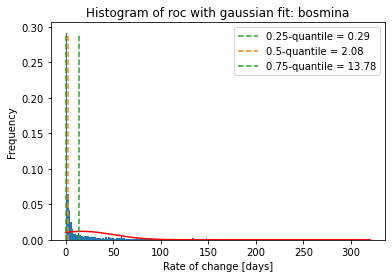

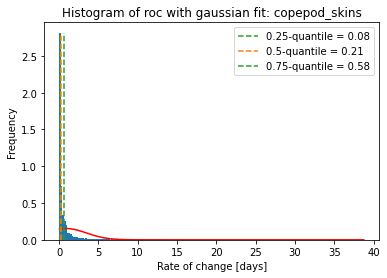

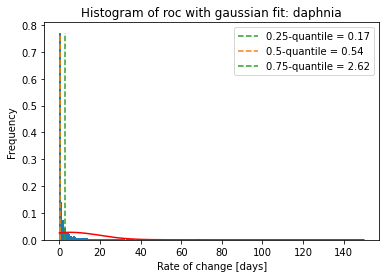

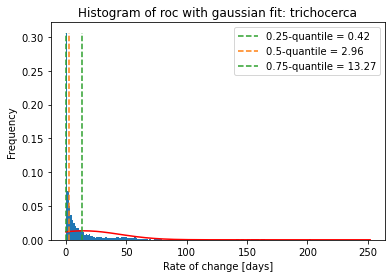

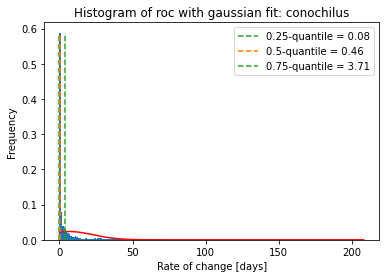

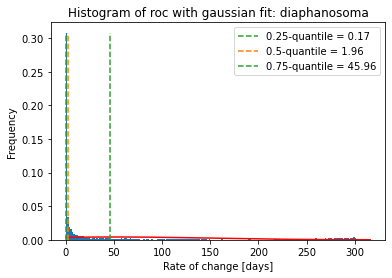

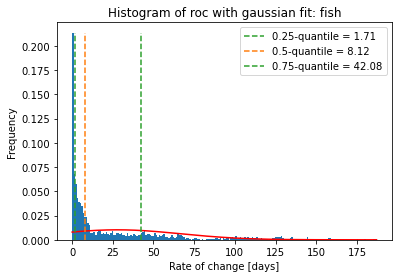

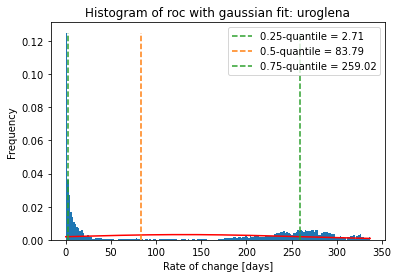

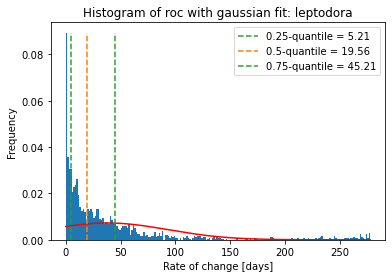

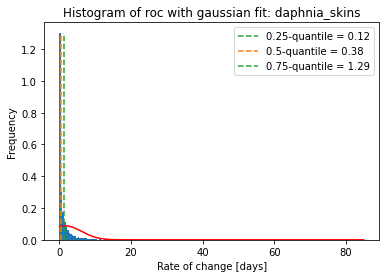

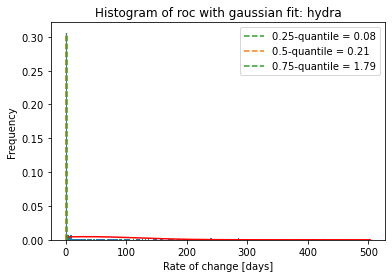

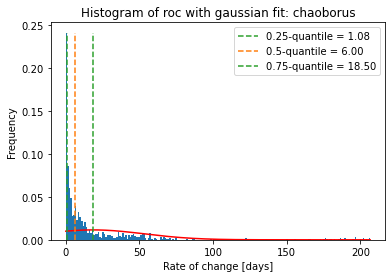

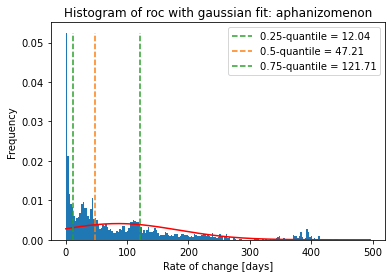

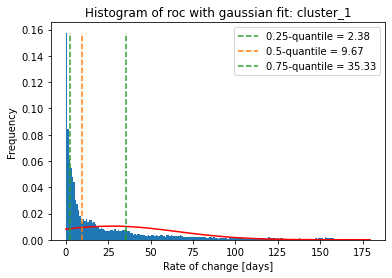

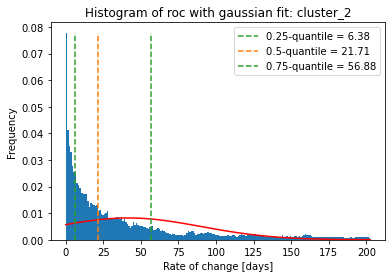

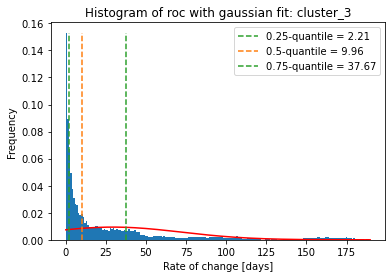

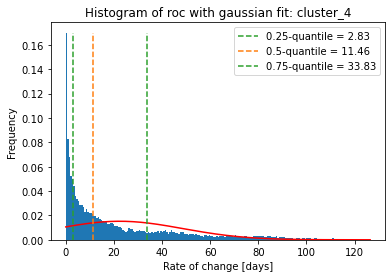

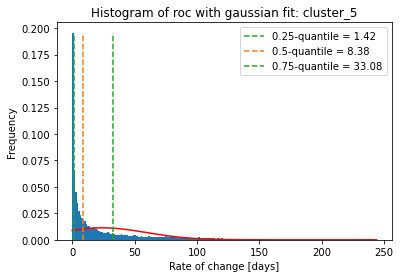

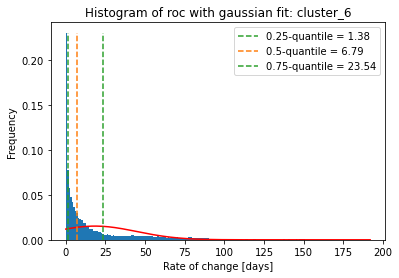

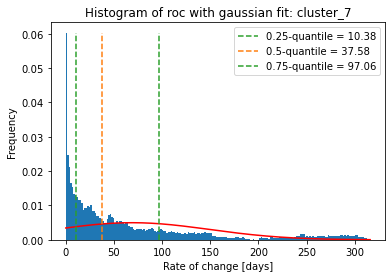

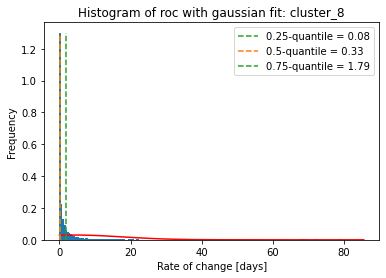

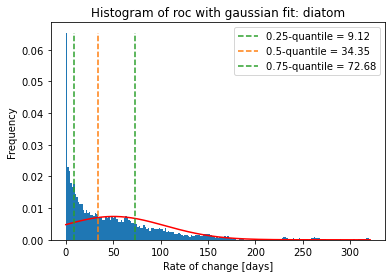

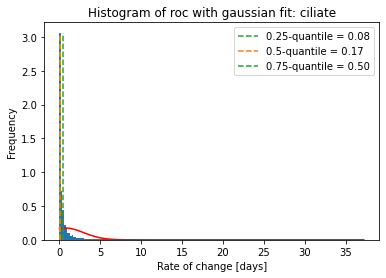

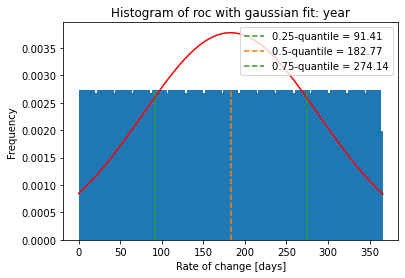

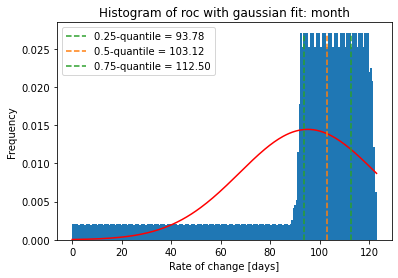

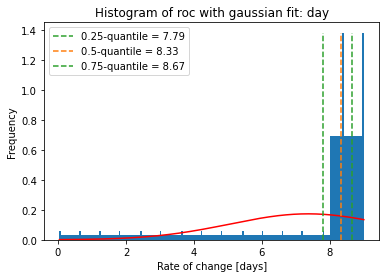

In [373]:
#print all the histograms:
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('roc_not_filtered.pdf')

for key in dfroc.keys():
     hist_roc(dfroc[key],key,pdf = pp)

pp.close()

In [374]:
df_medroc = dfroc.median()

In [375]:
df_medroc.to_csv(".\\median_roc_not_filtered.csv",na_rep='NA')

In [376]:
type(df_medroc)

pandas.core.series.Series